In [85]:
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm
from neo4j import GraphDatabase
import matplotlib.pyplot as plt

In [86]:
# Seen from :server status
uri = "bolt://localhost:7687"

# default user for graph database is neo4j
# auth = ("neo4j", "password")
auth = ("neo4j","quickstart")

driver = GraphDatabase.driver(uri = uri, auth = auth)
driver.verify_connectivity()

C:\Users\irsya\AppData\Local\Temp/ipykernel_16852/1292716654.py:9: ExperimentalWarning: The configuration may change in the future.
  driver.verify_connectivity()


'Neo4j/4.4.4'

In [87]:
members = pd.read_csv("../neo4j_quickstart/zach_karate_club/members.csv")
officers = members[members["Club"] == "Officer"]
main_club = members[members["Club"] == "Mr. Hi"]


#### Calculating Common Neighbors on Zach's Karate Club (<code> "../neo4j_quickstart/adv_importing.ipynb" </code>)

To run a graph algorithm, we first need to specify a portion of the graph we are going to use. In this case, let us use the whole graph.

@cypher:

    CALL gds.graph.project(
    'nameyourgraph',
    ["IncludedNodeType1", "IncludedNodetype2", "IncludedNodetype3"],
    {
        Includedrelationship: {orientation: "Natural"}
        Includedrelationship: {orientation: "Natural"}
        Includedrelationship: {orientation: "Natural"}
    }
    )

Documentation: 

    CALL gds.graph.project.cypher(
        graphName: String,
        nodesIncluded: [str]
        relationshipsIncluded: {
                                relationship: {orientation: "Natural" or "UNDIRECTED"}
                                relationship: {orientation: "Natural" or "UNDIRECTED"}
                                relationship: {orientation: "Natural" or "UNDIRECTED"}
                               }

In [88]:
class common_neighbors():
    """Class to run LinkPred"""
    def __init__(self) -> None:
        self.driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j", "quickstart"))

    def close(self) -> None:
        self.driver.close()

    @classmethod
    def LinkPred(cls, tx, id1, id2) -> any:
        """
        @param cls is the class
        @param tx is the transaction
        @return result.data() is the data
        """
        query = ("""
        MATCH (m:Person {id: $id1})
        MATCH (n:Person {id: $id2})
        RETURN m.id as Main_Club, n.id as Officers, gds.alpha.linkprediction.commonNeighbors(n, m) AS LinkPred_Score
        """)
        result = tx.run(query, id1 = id1, id2 = id2)
        return result.data()

    def push(self, main_club, officers) -> pd.DataFrame:
        common_neighbors = []
        print("Iterations:", len(main_club), flush=True)
        for i in tqdm(main_club["Id"], desc = "Iterating"):
            for j in officers["Id"]:
                common_neighbors.append(self.driver.session().write_transaction(self.LinkPred, i, j))
        print("Success")
        return common_neighbors

In [89]:
karate = common_neighbors()
data = karate.push(main_club, officers)

Iterations: 17


Iterating: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]

Success


In [90]:
officers = []
main_club = []
linkpred = []
for i in tqdm(range(len(data))):
    for j in range(len(data[i])):
        main_club.append(data[i][j]["Main_Club"])
        officers.append(data[i][j]["Officers"])
        linkpred.append(data[i][j]["LinkPred_Score"])


data = pd.DataFrame({"Officers": officers, "Main Club": main_club, "Common Neighbors": linkpred})

100%|██████████| 289/289 [00:00<00:00, 120122.27it/s]


In [91]:
data

,Officers,Main Club,Common Neighbors
0,9,0,1.0
1,14,0,0.0
2,15,0,0.0
3,18,0,0.0
4,20,0,0.0
...,...,...,...
284,29,21,0.0
285,30,21,1.0
286,31,21,1.0
287,32,21,0.0


In [93]:
data = data.pivot(index="Main Club", columns="Officers", values="Common Neighbors")
data

Officers,9,14,15,18,20,22,23,24,25,26,27,28,29,30,31,32,33
Main Club,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,2.0,0.0,3.0,4.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,3.0
2,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,6.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
8,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0


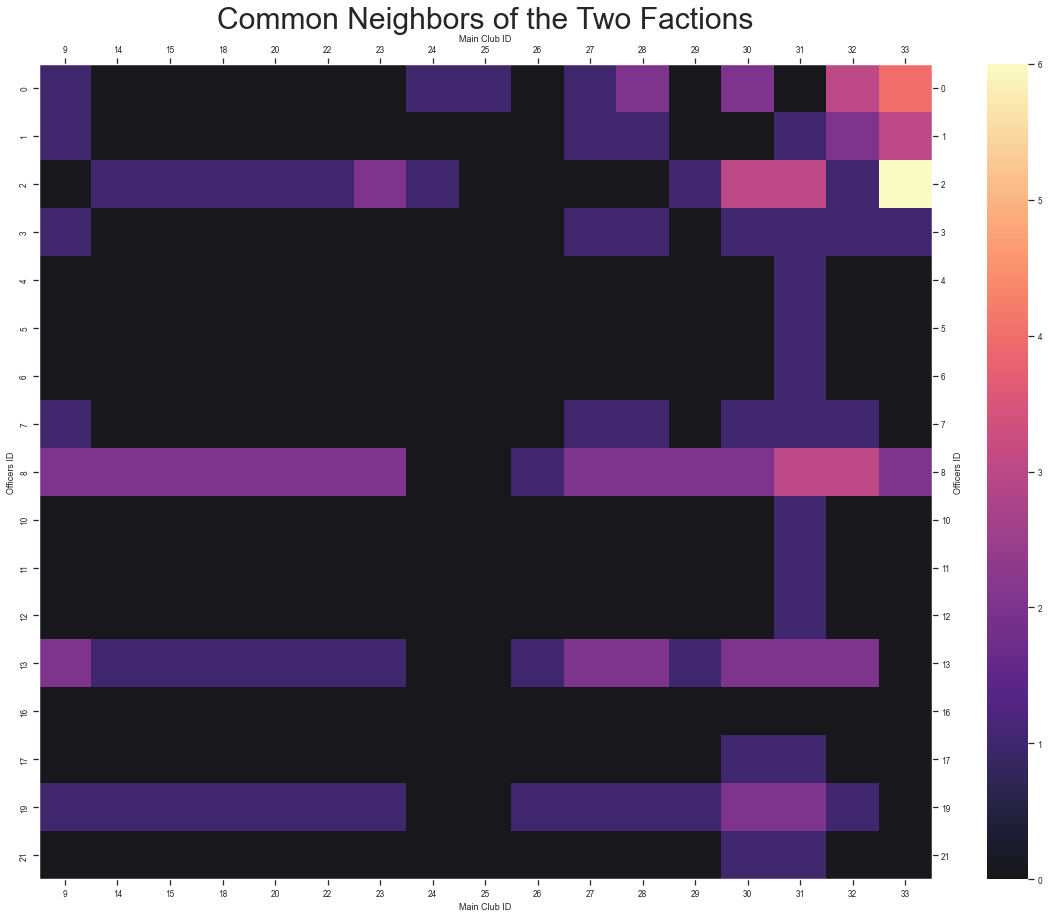

In [94]:
plt.figure(figsize=(20, 15))
sns.set_theme()
sns.set(font_scale=0.75)
ax = sns.heatmap(data = data, alpha=0.9, cmap = "magma")
ax.set_title("Common Neighbors of the Two Factions",  fontdict={'fontsize':30})
plt.xlabel("Main Club ID")
plt.ylabel("Officers ID")


ax1 = ax.twiny()
ax2 = ax.twinx()

ax1.set_xticks(ax.get_xticks())
ax1.set_xticklabels(ax.get_xticklabels())
ax1.set_xlabel(ax.get_xlabel())
ax1.set_xlim(ax.get_xlim())

ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(ax.get_yticklabels())
ax2.set_ylabel(ax.get_ylabel())
ax2.set_ylim(ax.get_ylim())

ax1.grid(False)
ax2.grid(False)